# Fit LDA ensemble

see: https://radimrehurek.com/gensim/auto_examples/tutorials/run_ensemblelda.html

In [3]:
import pickle
import pandas as pd
from gensim.models import LdaModel
from gensim.models import EnsembleLda
import numpy as np
import statistics
import os
from matplotlib import pyplot as plt 

%matplotlib inline

In [11]:
DATA_PATH = '../data'
MODELS_PATH = '../models'

## Load dictionary and corpus
Load the dictionary, tokenized train- and validate-corpus.

In [4]:
# Load the datasets for Computation and Language
with open(os.path.join(DATA_PATH, 'dictionary_cscl.pickle'), 'rb') as handle:
    dictionary_cscl = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_train_cscl.pickle'), 'rb') as handle:
    corpus_train_cscl = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_validate_cscl.pickle'), 'rb') as handle:
    corpus_validate_cscl = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_test_cscl.pickle'), 'rb') as handle:
    corpus_test_cscl = pickle.load(handle)

# Load the datasets for Gravitational Waves
with open(os.path.join(DATA_PATH, 'dictionary_gw.pickle'), 'rb') as handle:
    dictionary_gw = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_train_gw.pickle'), 'rb') as handle:
    corpus_train_gw = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_validate_gw.pickle'), 'rb') as handle:
    corpus_validate_gw = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_test_gw.pickle'), 'rb') as handle:
    corpus_test_gw = pickle.load(handle)

## Fit ensemble LDA

### Training

In [5]:
# parameters passed to the fit_ensemble_lda function
topic_model_class = LdaModel
ensemble_workers = 6
num_models = ensemble_workers * 2
distance_workers = 12
num_topics = 50
passes = 2

In [6]:
def fit_ensemble_lda(dictionary, corpus):
    """A function to train an ensemble LDA"""
    ensemble = EnsembleLda(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=passes,
        num_models=num_models,
        topic_model_class=topic_model_class,
        ensemble_workers=ensemble_workers,
        distance_workers=distance_workers
    )
    return(ensemble)

### Optimize the epsilon parameter

Parameters for optimizing the $\epsilon$ clustering parameter

In [7]:
max_runs = 5  # the number of times the LDA ensemble will be trained
steps = 25  # the number of steps covering the epsilon range

In [8]:
def get_shape_range(ensemble, steps):
    """Get the range of epsilon values for this ensemble"""
    shape = ensemble.asymmetric_distance_matrix.shape
    without_diagonal = ensemble.asymmetric_distance_matrix[~np.eye(shape[0], dtype=bool)].reshape(shape[0], -1)
    return(np.linspace(without_diagonal.min(), without_diagonal.max(), num=steps))

In [10]:
def compute_perplexity_for_ensemble(dictionary, corpus_train, corpus_validate, max_runs, steps):
    """
    Trains LDA ensemble 'max_run' times, each time with with 'steps' different values of epsilon, return perplexity values.
    @return: a list of dataframes, one dataframe for each run. Each row in the dataframe has 'k' num stable topics, 'eps' clustering parameter epsilon, 'val' perplexity value.
    """
    perplexity = []
    for run in range(max_runs):
        print(f"Run {run + 1} / {max_runs}")
        eps = []
        num_topics_eps = []
        px = []
        ensemble = fit_ensemble_lda(dictionary, corpus_train)
        shape_range = get_shape_range(ensemble, steps)
        for val in shape_range:
            ensemble.recluster(eps=val)
            len_topics = len(ensemble.get_topics())
            num_topics_eps.append(len_topics)
            eps.append(val)
            if len_topics > 1:
                # compute the perplexity for this value of epsilon
                log_perplexity = ensemble.log_perplexity(corpus_validate)
                perplexity_eps = np.exp(-log_perplexity)
                px.append(perplexity_eps)
#                print(f"eps: {val} stable number of topics: {len_topics}, perplexity: {perplexity_eps}")
            else:
                # there's 1 or no stable topics, perplexity is infinite
                px.append(np.inf)
        perplexity.append(pd.DataFrame.from_dict({'k': num_topics_eps, 'eps': eps, 'val': px}))
    return(perplexity)


CPU times: user 5 μs, sys: 3 μs, total: 8 μs
Wall time: 15.7 μs


### Compute perplexity by value of $\epsilon$ clustering parameter for the gravitational waves dataset

In [ ]:
%%time

perplexity_gw = compute_perplexity_for_ensemble(dictionary_gw, corpus_train_gw, corpus_validate_gw, max_runs, steps)

### Compute perplexity by value of $\epsilon$ clustering parameter for the computation and language dataset

In [ ]:
%%time

perplexity_cscl = compute_perplexity_for_ensemble(dictionary_cscl, corpus_train_cscl, corpus_validate_cscl, max_runs, steps)

## Plot the perplexity curves

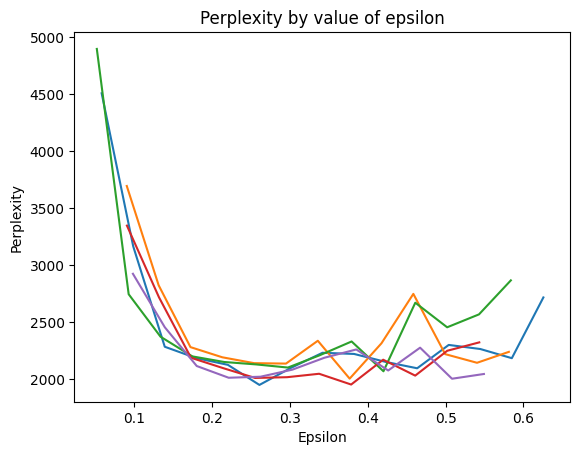

In [7]:
for run in range(max_runs):
    plt.plot(perplexity_gw[run].eps, perplexity_gw[run].val)
plt.title("Perplexity for the Gravitational Waves dataset")
plt.xlabel("Epsilon")
plt.ylabel("Perplexity")
plt.show()

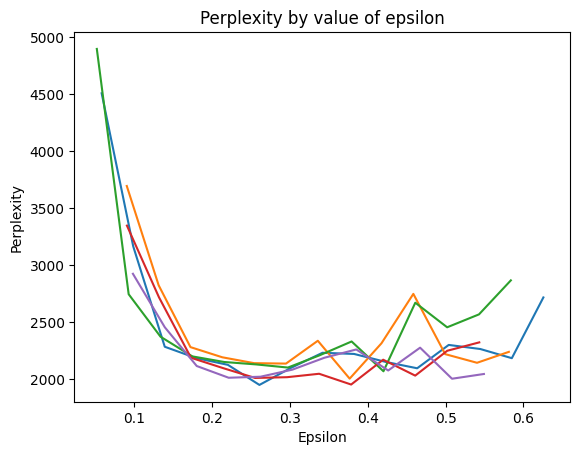

In [7]:
for run in range(max_runs):
    plt.plot(perplexity_cscl[run].eps, perplexity_cscl[run].val)
plt.title("Perplexity for the Computation and Language dataset")
plt.xlabel("Epsilon")
plt.ylabel("Perplexity")
plt.show()

### Find the best $\epsilon$ value: mode of list of best values for each run

In [14]:
def find_best_eps(max_runs, perplexity):
    best_eps_runs = []
    for run in range(max_runs):
        best_eps_runs.append(perplexity[run].sort_values('val', ascending=True).iloc[0]['eps'])
    best_eps = statistics.mode(best_eps_runs)


Best epsilon value after 5 runs is: 0.2608110486209746


In [ ]:
best_eps_gw = find_best_eps(max_runs, find_best_eps)
print(f"Best $\epsilon$ value for the Gravitational Waves dataset after {max_runs} runs is: {best_eps_gw}")

best_eps_cscl = find_best_eps(max_runs, find_best_cscl)
print(f"Best $\epsilon$ value for the Computation and Language dataset after {max_runs} runs is: {best_eps_cscl}")

## Gravitation waves topics
Refit the model, with best $\epsilon$, on the test dataset

In [20]:
ensemble_gw = fit_ensemble_lda(dictionary_gw, corpus_test_gw)
ensemble_gw.recluster(eps=best_eps_gw, min_samples=2, min_cores=2)
print(f"Found {len(ensemble_gw.print_topics())} stable topics for the Gravitation Waves dataset")
ensemble_gw.print_topics(num_words=5)

Found 10 stable topics


[(0,
  '0.037*"hole" + 0.036*"black" + 0.018*"binary" + 0.015*"mass" + 0.011*"spin"'),
 (1,
  '0.015*"model" + 0.014*"phase" + 0.014*"transition" + 0.013*"spectrum" + 0.010*"string"'),
 (2,
  '0.042*"pulsar" + 0.024*"timing" + 0.011*"array" + 0.011*"time" + 0.009*"data"'),
 (3,
  '0.038*"star" + 0.025*"neutron" + 0.009*"matter" + 0.009*"mass" + 0.009*"merger"'),
 (4,
  '0.018*"detector" + 0.016*"signal" + 0.013*"search" + 0.011*"noise" + 0.010*"frequency"'),
 (5,
  '0.028*"ray" + 0.019*"gamma" + 0.018*"emission" + 0.017*"burst" + 0.014*"grb"'),
 (6,
  '0.021*"theory" + 0.021*"field" + 0.017*"gravity" + 0.012*"general" + 0.012*"equation"'),
 (7,
  '0.033*"cmb" + 0.029*"polarization" + 0.024*"mode" + 0.016*"background" + 0.013*"primordial"'),
 (8,
  '0.053*"dark" + 0.036*"matter" + 0.017*"energy" + 0.009*"model" + 0.009*"phase"'),
 (9,
  '0.023*"mode" + 0.016*"polarization" + 0.014*"cmb" + 0.013*"data" + 0.012*"noise"')]

### Save the model

In [ ]:
with open(os.path.join(MODELS_PATH, 'ensemble_gw.pickle'), 'wb') as handle:
    pickle.dump(ensemble_gw, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Computation and Language topics
Refit the model, with best $\epsilon$, on the test dataset

In [20]:
ensemble_cscl = fit_ensemble_lda(dictionary_cscl, corpus_test_cscl)
ensemble_cscl.recluster(eps=best_eps_cscl, min_samples=2, min_cores=2)
print(f"Found {len(ensemble_cscl.print_topics())} stable topics for the Computation and Language dataset")
ensemble_cscl.print_topics(num_words=5)

Found 10 stable topics


[(0,
  '0.037*"hole" + 0.036*"black" + 0.018*"binary" + 0.015*"mass" + 0.011*"spin"'),
 (1,
  '0.015*"model" + 0.014*"phase" + 0.014*"transition" + 0.013*"spectrum" + 0.010*"string"'),
 (2,
  '0.042*"pulsar" + 0.024*"timing" + 0.011*"array" + 0.011*"time" + 0.009*"data"'),
 (3,
  '0.038*"star" + 0.025*"neutron" + 0.009*"matter" + 0.009*"mass" + 0.009*"merger"'),
 (4,
  '0.018*"detector" + 0.016*"signal" + 0.013*"search" + 0.011*"noise" + 0.010*"frequency"'),
 (5,
  '0.028*"ray" + 0.019*"gamma" + 0.018*"emission" + 0.017*"burst" + 0.014*"grb"'),
 (6,
  '0.021*"theory" + 0.021*"field" + 0.017*"gravity" + 0.012*"general" + 0.012*"equation"'),
 (7,
  '0.033*"cmb" + 0.029*"polarization" + 0.024*"mode" + 0.016*"background" + 0.013*"primordial"'),
 (8,
  '0.053*"dark" + 0.036*"matter" + 0.017*"energy" + 0.009*"model" + 0.009*"phase"'),
 (9,
  '0.023*"mode" + 0.016*"polarization" + 0.014*"cmb" + 0.013*"data" + 0.012*"noise"')]

### Save the model

In [ ]:
with open(os.path.join(MODELS_PATH, 'ensemble_cscl.pickle'), 'wb') as handle:
    pickle.dump(ensemble_cscl, handle, protocol=pickle.HIGHEST_PROTOCOL)